In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from catboost import CatBoostClassifier, Pool
import shap
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from feature_mapping import *
from sklearn.preprocessing import StandardScaler


/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df_5 = pd.read_spss('../data/caspian-5.sav',convert_categoricals=True)

In [5]:
from feature_mapping import map_feature, map_feature_4

# Step 1: Filter the dataset to keep only the features in the dictionary
features_to_keep = map_feature.keys()
df_5_filtered = df_5[list(features_to_keep)]

# Step 2: Rename the features based on the map_feature dictionary
df_5_filtered = df_5_filtered.rename(columns=map_feature)

# Step 3: Display the filtered and renamed dataset
print(df_5_filtered.head())


  university         grade gender  birth_date close_friend_count  \
0     tabriz     elemantry   girl        82.0             2 dost   
1      fasad  intermidiate   girl        81.0             1 dost   
2    ardebil     elemantry    boy        80.0          3 or more   
3   lorestan     elemantry    boy        80.0          3 or more   
4  kurdestan  intermidiate    boy        79.0          3 or more   

  spent_time_friend1 spent_time_friend2 chatting_online   body_image  \
0              0 roz              0 roz           never       normal   
1              0 roz              0 roz           never  kami laghar   
2              3 roz              4 roz  5 or 6 in week       normal   
3              0 roz              0 roz           never       normal   
4              2 roz              1 roz           never       normal   

  diet_plan  ... reduce_fat use_liquid_oil increase_vegetables reduce_sugar  \
0      khub  ...         no             no                 yes          yes   


change ap_17 to ap_21 as livingparent and remove them

In [6]:
def determine_livingparent(row):
    if row["ap_17"] == "yes" and row["ap_18"] == "yes":
        return "Ba hardo"
    elif row["ap_17"] == "yes" or row["ap_18"] == "yes":
        return "Ba yeki az valedayn"
    else:
        return "Napedar v na madar"

df_5_filtered["livingparent"] = df_5_filtered.apply(determine_livingparent, axis=1)
df_5_filtered.drop(['ap_17','ap_18','ap_19','ap_20','ap_21'],axis=1,inplace=True)
df_5_filtered['source']='casp 5'

In [7]:
df_5_filtered.shape

(13983, 128)

upload dataset 4

In [8]:
from feature_mapping import map_feature_4
df_4 = pd.read_spss('../final_data/caspian4-ghorbani.sav')
features_to_keep = map_feature_4.keys()
df_4_filtered = df_4[list(features_to_keep)]

df_4_filtered = df_4_filtered.rename(columns=map_feature_4)
df_4_filtered['source']='casp 4'
# Step 4: Display the filtered dataset
print(df_4_filtered.head())

        university      grade gender  birth_date close_friend_count  \
0  khozestan-ahvaz  rahnamayi    boy        79.0               yeki   
1  khozestan-ahvaz  rahnamayi    boy        74.0     3ta va bishtar   
2          boshehr   ebtedayi   girl        80.0     3ta va bishtar   
3          ardabil  rahnamayi   girl        78.0                2ta   
4          ardabil   ebtedayi   girl        81.0               yeki   

  spent_time_friend1 spent_time_friend2       chatting_online body_image  \
0           hich ruz               3ruz  5 ya 6 ruz dar hafte  kami chag   
1               2ruz               2ruz   1 ya 2ruz dar hafte     normal   
2           hich ruz               2ruz  5 ya 6 ruz dar hafte  kamilagar   
3               5ruz               4ruz  3 ya 4 ruz dar hafte  kamilagar   
4               1ruz               1ruz   1 ya 2ruz dar hafte     normal   

      diet_plan  ... reduce_fast_food increase_vegetables reduce_salt  \
0  no wt ok ast  ...               no      

In [9]:
combined_df = pd.concat([df_4_filtered, df_5_filtered], ignore_index=True)

# Display the combined dataset
combined_df.columns

Index(['university', 'grade', 'gender', 'birth_date', 'close_friend_count',
       'spent_time_friend1', 'spent_time_friend2', 'chatting_online',
       'body_image', 'diet_plan',
       ...
       'reduce_fast_food', 'increase_vegetables', 'reduce_salt',
       'reduce_sugar', 'reduce_fat', 'use_liquid_oil', 'injury_parent_ask',
       'injury_complication', 'region', 'source'],
      dtype='object', length=128)

In [10]:
import re
combined_df.replace('', np.nan, inplace=True)
combined_df.replace('rarely','seldom/never',inplace=True)
combined_df.replace('never','seldom/never',inplace=True)

combined_df.replace('hichvaght','seldom/never',inplace=True)
combined_df.replace({'hich ruz': '0 day', 'hich ruzi': '0 day'}, inplace=True)

categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    combined_df[col] = combined_df[col].apply(lambda x: x.lower() if isinstance(x, str) and x != '' else np.nan)
    combined_df[col] = combined_df[col].apply(lambda x: x.strip() if isinstance(x, str) and x != '' else np.nan)
    combined_df[col] = combined_df[col].apply(lambda x: re.sub(r'(\d)(\w)', r'\1 \2', str(x)) if isinstance(x, str) else x)
    combined_df[col] = combined_df[col].apply(lambda x: str(x).replace('ruzi', 'day').replace('ruz', 'day').replace('roz', 'day') if isinstance(x, str) else x)
    combined_df[col] = combined_df[col].apply(lambda x: str(x).replace('hours', 'hour').replace('saat', 'hour') if isinstance(x, str) else x)
    combined_df[col] = combined_df[col].apply(lambda x: re.sub(r'(\d)\s*ta\s*(\d)', r'\1-\2', str(x)) if isinstance(x, str) else x)
    

In [11]:
# Standardize column names
df_4_filtered.columns = df_4_filtered.columns.str.strip().str.lower()
df_5_filtered.columns = df_5_filtered.columns.str.strip().str.lower()

# Compare again
print("Columns in df1 but not in df2:", set(df_4_filtered.columns) - set(df_5_filtered.columns))
print("Columns in df2 but not in df1:", set(df_5_filtered.columns) - set(df_4_filtered.columns))


Columns in df1 but not in df2: set()
Columns in df2 but not in df1: set()


In [12]:
categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns

# Get unique values for each categorical column
unique_values = {col: combined_df[col].dropna().unique().tolist() for col in categorical_columns}

# Print the results
for col, values in unique_values.items():
    print(f"Column: {col}, Unique Values: {values}")

Column: university, Unique Values: ['khozestan-ahvaz', 'boshehr', 'ardabil', 'azar garbi', 'khorasan shomali-bojnord', 'qazvin', 'lorestan', 'khorasan razavi-mashad', 'kordestan', 'yazd', 'kerman-kerman', 'kermanshah', 'isfahan', 'markazi', 'shahid beheshti', 'sistan-zabol', 'ilam', 'kohkiloye', '4 mahal bakhtiyari', 'hormzgan', 'sistan-zahedan', 'semnan-semnan', 'golestan', 'mazandaran-babol', 'kerman-jiroft', 'hamadan', 'semnan-shahrod', 'khozestan-dezfol', 'alborz', 'kerman-rafsanjan', 'azar shargi', 'zanjan', 'fars-shiraz', 'gilan', 'qom', 'fars-jahrom', 'isfahan-kashan', 'tehran', 'khorasan razavi-sabzavar', 'khorasan razavi-neishabor', 'fars-fasa', 'tabriz', 'fasad', 'ardebil', 'kurdestan', 'khorasan shomali', 'charmahal', 'khorasan jonobi', 'azar gharbi', 'mazandaran', 'kohkiloyeh', 'babol', 'rafsanjan', 'zabol', 'hormozgan', 'arak', 'khozestan', 'kerman', 'semnan', 'hamedan', 'behbahan', 'kerman.jiroft', 'khorasan razavi', 'esfarayen', 'iran', 'saveh', 'dezful', 'neishabor', 'a

In [13]:
from feature_mapping import mapping_university
combined_df['university'] = combined_df['university'].apply(lambda x: mapping_university.get(x, x))

In [14]:
from feature_mapping import mapping_grade
combined_df['grade'] = combined_df['grade'].apply(lambda x: mapping_grade.get(x, x))

In [15]:
from feature_mapping import mapping_close_friend_count
combined_df['close_friend_count'] = combined_df['close_friend_count'].apply(lambda x: mapping_close_friend_count.get(x, x))

In [16]:
from feature_mapping import mapping_chatting_online
combined_df['chatting_online'] = combined_df['chatting_online'].apply(lambda x: mapping_chatting_online.get(x, x))

In [17]:
from feature_mapping import mapping_body_img
combined_df['body_image'] = combined_df['body_image'].apply(lambda x: mapping_body_img.get(x, x))

In [18]:
from feature_mapping import mapping_diet_plan
combined_df['diet_plan'] = combined_df['diet_plan'].apply(lambda x: mapping_diet_plan.get(x, x))

In [19]:
from feature_mapping import mapping_breakfast_routindays
combined_df['breakfast_routindays'] = combined_df['breakfast_routindays'].apply(lambda x: mapping_breakfast_routindays.get(x, x))

In [20]:
from feature_mapping import mapping_breakfast_friday
combined_df['breakfast_friday'] = combined_df['breakfast_friday'].apply(lambda x: mapping_breakfast_friday.get(x, x))

In [21]:
from feature_mapping import mapping_lunch_routindays,mapping_lunch_friday,mapping_dinner_routindays
combined_df['lunch_routinday'] = combined_df['lunch_routinday'].apply(lambda x: mapping_lunch_routindays.get(x, x))
combined_df['lunch_friday'] = combined_df['lunch_friday'].apply(lambda x: mapping_lunch_friday.get(x, x))
combined_df['dinner_routinday'] = combined_df['dinner_routinday'].apply(lambda x: mapping_dinner_routindays.get(x, x))
combined_df['dinner_friday'] = combined_df['dinner_friday'].apply(lambda x: mapping_lunch_friday.get(x, x))


In [22]:
from feature_mapping import mapping_screen_timing
combined_df['TV_watching_routinday'] = combined_df['TV_watching_routinday'].apply(lambda x: mapping_screen_timing.get(x, x))
combined_df['TV_watching_friday'] = combined_df['TV_watching_friday'].apply(lambda x: mapping_screen_timing.get(x, x))
combined_df['computer_work_routinday'] = combined_df['computer_work_routinday'].apply(lambda x: mapping_screen_timing.get(x, x))
combined_df['computer_work_friday'] = combined_df['computer_work_friday'].apply(lambda x: mapping_screen_timing.get(x, x))

In [23]:
from feature_mapping import (
    mapping_injury_times,
    mapping_injury_place,
    mapping_injury_treatment_place,
    mapping_fight_number,
    mappling_litigant,
    mapping_carry_weapons,
    mapping_victim_number,
    mapping_bully_number,
)
from feature_mapping import mapping_injury_cause

combined_df["injury_number"] = combined_df["injury_number"].apply(
    lambda x: mapping_injury_times.get(x, x)
)
combined_df["injury_place"] = combined_df["injury_place"].apply(
    lambda x: mapping_injury_place.get(x, x)
)
combined_df["injury_cause"] = combined_df["injury_cause"].apply(
    lambda x: mapping_injury_cause.get(x, x)
)
combined_df["injury_treatment_place"] = combined_df["injury_treatment_place"].apply(
    lambda x: mapping_injury_treatment_place.get(x, x)
)
combined_df["fight_number"] = combined_df["fight_number"].apply(
    lambda x: mapping_fight_number.get(x, x)
)
combined_df["litigant"] = combined_df["litigant"].apply(
    lambda x: mappling_litigant.get(x, x)
)
combined_df["carry_weapons"] = combined_df["carry_weapons"].apply(
    lambda x: mapping_carry_weapons.get(x, x)
)
combined_df["victim_number"] = combined_df["victim_number"].apply(
    lambda x: mapping_victim_number.get(x, x)
)
combined_df["bully_number"] = combined_df["bully_number"].apply(
    lambda x: mapping_bully_number.get(x, x)
)


In [24]:
from feature_mapping import mapping_feeling_number

feeling = [
    "confusion_number",
    "worthless_number",
    "insomnia_number",
    "back_pain_number",
    "headache_number",
    "worried_number",
    "stomach_ache_number",
    "angriness_number",
]
for col in feeling:
    combined_df[col] = combined_df[col].apply(
        lambda x: mapping_feeling_number.get(x, x)
    )

In [25]:
from feature_mapping import mapping_depression
combined_df['depression']=combined_df['depression'].apply(lambda x: mapping_depression.get(x,x))

In [26]:
from feature_mapping import mapping_anxiety
combined_df['anxiety_number']=combined_df['anxiety_number'].apply(lambda x: mapping_anxiety.get(x,x))

In [27]:
from feature_mapping import mappingـmental_health
combined_df['mental_health_overview']=combined_df['mental_health_overview'].apply(lambda x: mappingـmental_health.get(x,x))

In [28]:
from feature_mapping import mapping_catage
combined_df = combined_df[(combined_df['age'] >= 7) & (combined_df['age'] <= 18)]
combined_df['catage']=combined_df['catage'].apply(lambda x: mapping_catage.get(x,x))
combined_df['catage'].value_counts()


1    10141
0     9082
2     7959
Name: catage, dtype: int64

In [29]:
from feature_mapping import mapping_smoking_type
combined_df['smoking_type']=combined_df['smoking_type'].apply(lambda x: mapping_smoking_type.get(x,x))

In [30]:
from feature_mapping import mapping_home_ownership
combined_df['home_ownership']=combined_df['home_ownership'].apply(lambda x: mapping_home_ownership.get(x,x))

In [31]:
from feature_mapping import mapping_edu
combined_df['father_edu']=combined_df['father_edu'].apply(lambda x: mapping_edu.get(x,x))
combined_df['mother_edu']=combined_df['mother_edu'].apply(lambda x: mapping_edu.get(x,x))


In [32]:
from feature_mapping import (
    father_job_mapping,
    mother_job_mapping,
    school_type_mapping,
    birth_weight_mapping,
    milk_type_mapping,
    complementary_feeding_mapping,
)

combined_df["father_job"] = combined_df["father_job"].apply(
    lambda x: father_job_mapping.get(x, x)
)
combined_df["mother_job"] = combined_df["mother_job"].apply(
    lambda x: mother_job_mapping.get(x, x)
)
combined_df["school_type"] = combined_df["school_type"].apply(
    lambda x: school_type_mapping.get(x, x)
)
combined_df["birth_weight"] = combined_df["birth_weight"].apply(
    lambda x: birth_weight_mapping.get(x, x)
)
combined_df["milk_type"] = combined_df["milk_type"].apply(
    lambda x: milk_type_mapping.get(x, x)
)
combined_df["complementary_feeding"] = combined_df["complementary_feeding"].apply(
    lambda x: complementary_feeding_mapping.get(x, x)
)


In [33]:
combined_df['bread_type'].replace({
    'bedune sabus': 'White bread',
    'sabusdar': 'whole grain bread',
    'sabus dar': 'whole grain bread'
},inplace=True)



In [34]:
combined_df['oil_type']=combined_df['oil_type'].apply(lambda x:oil_type_mapping.get(x,x))
combined_df['table_salt']=combined_df['table_salt'].apply(lambda x:table_salt_mapping.get(x,x))
combined_df['dairy_type']=combined_df['dairy_type'].apply(lambda x:dairy_type_mapping.get(x,x))
combined_df['injury_complication']= combined_df['injury_complication'].apply(lambda x:injury_complication_mapping.get(x,x))

In [35]:
categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns
# Get unique values for each categorical column
unique_values = {col: combined_df[col].dropna().unique().tolist() for col in categorical_columns}

# Print the results
for col, values in unique_values.items():
    print(f"Column: {col}, Unique Values: {values}")

Column: university, Unique Values: ['khozestan', 'bushehr', 'ardabil', 'azar gharbi', 'khorasan shomali', 'qazvin', 'lorestan', 'khorasan razavi', 'kordestan', 'yazd', 'kerman', 'kermanshah', 'isfahan', 'markazi', 'shahid beheshti', 'ilam', 'kohgiluyeh', 'chaharmahal bakhtiyari', 'hormozgan', 'sistan', 'semnan', 'golestan', 'mazandaran', 'jiroft', 'hamedan', 'dezful', 'alborz', 'rafsanjan', 'azar sharghi', 'zanjan', 'fars', 'gilan', 'qom', 'jahrom', 'kashan', 'tehran', 'sabzevar', 'neishabor', 'fasa', 'tabriz', 'khorasan jonoubi', 'babol', 'zabol', 'arak', 'behbahan', 'esfarayen', 'iran', 'saveh', 'abadan', 'torbat jam', 'iranshahr', 'torbat heidariyeh', 'bam', 'shahrood', 'shushtar', 'larestan']
Column: grade, Unique Values: ['intermediate', 'elementary']
Column: gender, Unique Values: ['boy', 'girl']
Column: close_friend_count, Unique Values: ['one', 'three or more', 'two', 'any']
Column: spent_time_friend1, Unique Values: ['0 day', '2 day', '5 day', '1 day', '4 day', '6 day', '3 day

In [36]:
!pwd

/home/atefe_hjn97/Documents/VScode/caspian_second/casp 5


In [37]:
# combined_df.to_csv('combined_data_alignment_4&5_v1.csv')

missing value handling

In [38]:
df=combined_df.copy()
df = df[df['source']=='casp 5']
df = df[df['gender']=='boy']

drop column with over 80 percent missing value

In [39]:
to_drop_col = []
for column in df.columns:
    null_percentage = df[column].isnull().mean()*100
    print(f"Column '{column}' has {null_percentage} null values.")
    if null_percentage>20:
        to_drop_col.append(column)
print(df.shape)
df=df.drop(to_drop_col,axis=1)
print(df.shape)


Column 'university' has 0.0 null values.
Column 'grade' has 0.0 null values.
Column 'gender' has 0.0 null values.
Column 'birth_date' has 0.0 null values.
Column 'close_friend_count' has 0.155257586450247 null values.
Column 'spent_time_friend1' has 0.1834862385321101 null values.
Column 'spent_time_friend2' has 0.08468595624558928 null values.
Column 'chatting_online' has 0.12702893436838392 null values.
Column 'body_image' has 0.028228652081863093 null values.
Column 'diet_plan' has 0.6633733239237827 null values.
Column 'breakfast_routindays' has 0.22582921665490474 null values.
Column 'breakfast_friday' has 0.7621736062103035 null values.
Column 'lunch_routinday' has 0.2399435426958363 null values.
Column 'lunch_friday' has 0.7339449541284404 null values.
Column 'dinner_routinday' has 0.08468595624558928 null values.
Column 'dinner_friday' has 0.7621736062103035 null values.
Column 'sweet' has 0.0 null values.
Column 'saltysnack' has 0.4798870853916726 null values.
Column 'soda' ha

fill null value

In [40]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
for col in numerical_columns:
    if df[col].isna().any():  # Only process columns with missing values
        df[col] = df.groupby('age')[col].transform(
            lambda x: x.fillna(x.mean())
        )
for col in categorical_columns:
    # Fill null values with the mode of the column within each age group
    if df[col].isna().any():  # Only process columns with missing values
        df[col] = df.groupby('age')[col].transform(
            lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
        )

bmi calculation

In [41]:
df["bmi"] = df["weight"] / ((df["height"] / 100) ** 2)

/tmp/ipykernel_23660/2046101176.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["bmi"] = df["weight"] / ((df["height"] / 100) ** 2)


In [42]:
df_who_ref = pd.read_excel('../WHO_tables/bmi-boys-perc-who2007-exp.xlsx')
# Define the age range and convert it to months
age_years = list(range(7, 19))  # From 7 to 18 years inclusive
age_months = [age * 12 for age in age_years]

# Filter the dataset for the specified months and select relevant columns
who_df = df_who_ref[df_who_ref['Month'].isin(age_months)][['Month', 'P5', 'P15', 'P85', 'P95']]

# Map months back to years for clarity
who_df['Age'] = who_df['Month'] // 12
filtered_df = who_df.drop(columns=['Month'])

who_df = who_df.reset_index(drop=True)
who_df

,Month,P5,P15,P85,P95,Age
0,84,13.504,14.166,17.111,18.261,7
1,96,13.666,14.350,17.508,18.802,8
2,108,13.866,14.579,17.987,19.453,9
3,120,14.127,14.875,18.568,20.225,10
4,132,14.469,15.260,19.260,21.113,11
5,144,14.891,15.734,20.052,22.090,12
6,156,15.402,16.303,20.943,23.144,13
7,168,15.976,16.941,21.891,24.221,14
8,180,16.547,17.580,22.812,25.229,15
9,192,17.078,18.176,23.656,26.126,16


In [43]:
def calculate_percentile_labels(row, who_ref):
    """
    Categorizes BMI based on WHO reference percentiles for the corresponding age.
    """
    age = row['age']
    bmi = row['bmi']
    
    # Filter WHO reference data for the specific age
    ref_data = who_ref[who_ref['Age'] == age]
    
    if ref_data.empty:
        return 'Unknown'  # Handle cases where reference data is not available
    
    # Extract the percentiles
    p5 = ref_data['P5'].values[0]
    p85 = ref_data['P85'].values[0]
    p95 = ref_data['P95'].values[0]
    
    # Categorize based on percentiles
    if bmi < p5:
        return 'underweight'
    elif p5 <= bmi < p85:
        return 'normal'
    elif p85 <= bmi < p95:
        return 'overweight'
    else:
        return 'overweight'

def calculate_percentiles(df_org, who_ref):
    """
    Adds a percentile category for each row based on WHO reference data.
    """
    df = df_org.copy()
    
    # Apply the function to calculate percentile categories
    df['bmi_category'] = df.apply(
        lambda row: calculate_percentile_labels(row, who_ref), axis=1
    )

    return df

In [44]:
# Use the WHO reference dataframe (df_who_ref)
df = calculate_percentiles(df, who_df)

df[['age','bmi','height','weight','bmi_category']].head()


,age,bmi,height,weight,bmi_category
13544,14.0,18.902038,156.000000,46.000000,normal
13545,14.0,15.245707,151.300003,34.900002,underweight
13546,15.0,17.781971,166.000000,49.000000,normal
13551,17.0,25.624543,185.000000,87.699997,overweight
13552,9.0,24.460295,178.000000,77.500000,overweight


/tmp/ipykernel_23660/159732643.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


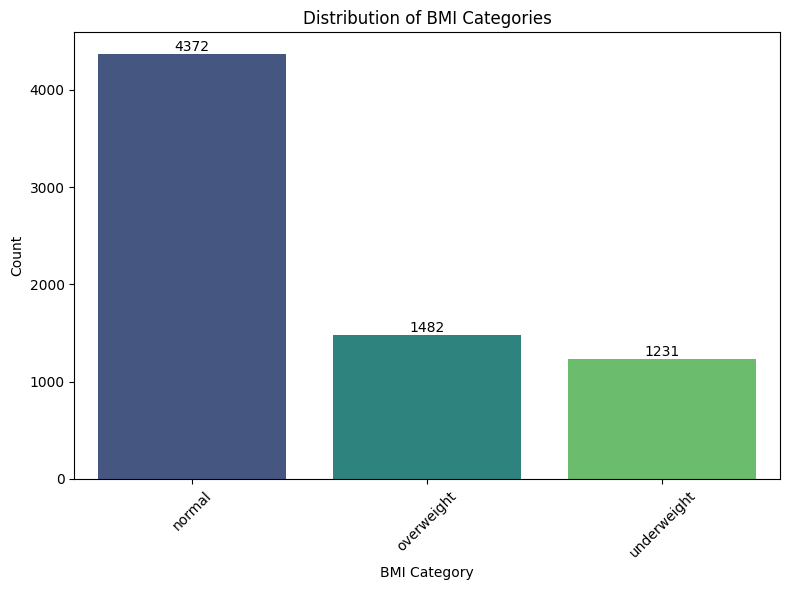

In [45]:
def plot_bmi_categories(df, feature):

        category_counts = df[f'{feature}_category'].value_counts()

        # Plot the counts
        plt.figure(figsize=(8, 6))
        ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')

        # Annotate counts above each bar
        for i, count in enumerate(category_counts.values):
            ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

        # Customize plot
        plt.title(f"Distribution of BMI Categories")
        plt.xlabel("BMI Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_bmi_categories(df,'bmi')


In [46]:
# def frequency_encode(df, categorical_columns,numerical_columns, group_by_column='age'):
#     """
#     Applies frequency encoding to the specified columns in the dataframe, filling null values with the mode based on each age group.

#     Parameters:
#         df (pd.DataFrame): The input dataframe.
#         columns (list): List of categorical columns to be frequency encoded.
#         group_by_column (str): The column name to group by (default is 'age').

#     Returns:
#         pd.DataFrame: A dataframe with frequency-encoded columns.
#     """
#     df_encoded = df.copy()

#     for col in categorical_columns:
#         # Calculate the frequency for encoding after filling missing values
#         if col != 'bmi_category':
#             frequency = df_encoded[col].value_counts() / len(df_encoded)
        
#             # Apply frequency encoding
#             df_encoded[col] = df_encoded[col].map(frequency)
#         else:
#              class_mapping = {'abnormal':0,'normal':1}
#              df_encoded[col]=df_encoded[col].map(class_mapping)

#     return df_encoded

# # Example Usage
# # Assuming 'df' is your dataframe
# categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
# df_encoded = frequency_encode(df, categorical_columns,numerical_columns)


In [47]:
numerical_data = df.select_dtypes(include=['number'])
df[numerical_data.columns].describe()
numerical_data_selected = ['sleep_hours_routinday','sleep_hours_friday','family_size','breast_feeding_duration']
df[numerical_data_selected].describe()


,sleep_hours_routinday,sleep_hours_friday,family_size,breast_feeding_duration
count,7085.000000,7085.000000,7085.000000,7085.000000
mean,8.405514,9.523285,4.838431,15.147376
std,1.305148,1.532903,1.406329,8.379566
min,4.000000,4.000000,2.000000,0.000000
25%,8.000000,9.000000,4.000000,6.000000
50%,8.000000,9.467188,5.000000,18.000000
75%,9.000000,10.000000,5.000000,24.000000
max,15.000000,18.000000,11.000000,24.000000


In [48]:
categorical_data = df.select_dtypes(include=['object'])
df[categorical_data.columns].describe()

,university,grade,gender,close_friend_count,spent_time_friend1,spent_time_friend2,chatting_online,body_image,diet_plan,breakfast_routindays,...,reduce_fast_food,increase_vegetables,reduce_salt,reduce_sugar,reduce_fat,use_liquid_oil,injury_parent_ask,region,source,bmi_category
count,7085,7085,7085,7085,7085,7085,7085,7085,7085,7085,...,7085,7085,7085,7085,7085,7085,7085,7085,7085,7085
unique,51,2,1,4,7,7,5,5,4,7,...,2,2,2,2,2,2,2,2,1,3
top,alborz,elementary,boy,three or more,0 day,0 day,seldom/never,normal weight,weight is fine,6 day,...,yes,yes,yes,yes,yes,no,no,urban,casp 5,normal
freq,269,4066,7085,3712,4914,3967,3635,3039,3176,4290,...,4735,4366,3788,3698,3569,3740,6653,5027,7085,4372


In [49]:
df_copy = df.copy()

In [50]:
df_copy.shape

(7085, 122)

In [51]:
categorical_data = df_copy.select_dtypes(include=['object'])
a = df_copy[categorical_data.columns].describe()
a

,university,grade,gender,close_friend_count,spent_time_friend1,spent_time_friend2,chatting_online,body_image,diet_plan,breakfast_routindays,...,reduce_fast_food,increase_vegetables,reduce_salt,reduce_sugar,reduce_fat,use_liquid_oil,injury_parent_ask,region,source,bmi_category
count,7085,7085,7085,7085,7085,7085,7085,7085,7085,7085,...,7085,7085,7085,7085,7085,7085,7085,7085,7085,7085
unique,51,2,1,4,7,7,5,5,4,7,...,2,2,2,2,2,2,2,2,1,3
top,alborz,elementary,boy,three or more,0 day,0 day,seldom/never,normal weight,weight is fine,6 day,...,yes,yes,yes,yes,yes,no,no,urban,casp 5,normal
freq,269,4066,7085,3712,4914,3967,3635,3039,3176,4290,...,4735,4366,3788,3698,3569,3740,6653,5027,7085,4372


In [52]:
from sklearn.preprocessing import OrdinalEncoder

# Step 1: Select columns with valid day values
day_columns = [col for col in df_copy.columns if df_copy[col].dtype == 'object' and 
               all(day in df_copy[col].unique() for day in ['0 day', '1 day', '2 day', '3 day', '4 day', '5 day', '6 day'])]
print(day_columns)

# Step 3: Define the ordinal encoder with the correct categories list
ordinal_encoder = OrdinalEncoder(categories=[['0 day', '1 day', '2 day', '3 day', '4 day', '5 day', '6 day']])

# Apply the transformation to all the columns
for col in day_columns[:-1]:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])  # Use double square brackets to keep it 2D

    # Step 5: Check the value counts of the transformed columns
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())


['spent_time_friend1', 'spent_time_friend2', 'breakfast_routindays', 'lunch_routinday', 'physical_activity']
Value counts for spent_time_friend1:
0.0    4914
1.0     688
2.0     510
6.0     440
3.0     262
4.0     160
5.0     111
Name: spent_time_friend1, dtype: int64
Value counts for spent_time_friend2:
0.0    3967
1.0    1277
2.0     667
6.0     553
3.0     365
4.0     202
5.0      54
Name: spent_time_friend2, dtype: int64
Value counts for breakfast_routindays:
6.0    4290
5.0    1564
4.0     361
3.0     252
0.0     222
2.0     202
1.0     194
Name: breakfast_routindays, dtype: int64
Value counts for lunch_routinday:
6.0    4844
5.0    1514
4.0     261
1.0     153
2.0     147
3.0      86
0.0      80
Name: lunch_routinday, dtype: int64


In [53]:
from sklearn.preprocessing import OrdinalEncoder
print(df_copy['close_friend_count'].value_counts())

ordinal_encoder = OrdinalEncoder(categories=[['any', 'one', 'two', 'three or more']])

# Apply to 'close_friend_count' column
df_copy['close_friend_count'] = ordinal_encoder.fit_transform(df_copy[['close_friend_count']])
df_copy['close_friend_count'].value_counts()


three or more    3712
two              1905
one              1174
any               294
Name: close_friend_count, dtype: int64


3.0    3712
2.0    1905
1.0    1174
0.0     294
Name: close_friend_count, dtype: int64

In [54]:
from sklearn.preprocessing import LabelEncoder
yes_no_columns = [col for col in df_copy.columns if df_copy[col].dtype == 'object' and df_copy[col].isin(['yes', 'no']).all()]

label_encoder = LabelEncoder()

# Apply Label Encoding to each 'Yes/No' column
for col in yes_no_columns:
    df_copy[col] = label_encoder.fit_transform(df_copy[col])

In [55]:
daily_columns = [col for col in df_copy.columns if df_copy[col].dtype == 'object' and df_copy[col].isin(['seldom/never','weekly','daily']).all()]
ordinal_encoder = OrdinalEncoder(categories=[['seldom/never','weekly','daily']])

# Apply the transformation to all the columns
for col in daily_columns:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])  # Use double square brackets to keep it 2D

    # Step 5: Check the value counts of the transformed columns
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())


Value counts for sweet:
1.0    2981
0.0    2616
2.0    1488
Name: sweet, dtype: int64
Value counts for saltysnack:
0.0    4735
1.0    1961
2.0     389
Name: saltysnack, dtype: int64
Value counts for soda:
0.0    3982
1.0    2554
2.0     549
Name: soda, dtype: int64
Value counts for dry_fruit:
1.0    2991
2.0    2328
0.0    1766
Name: dry_fruit, dtype: int64
Value counts for fresh_juice:
0.0    3409
1.0    2492
2.0    1184
Name: fresh_juice, dtype: int64
Value counts for packed_juice:
0.0    3988
1.0    2342
2.0     755
Name: packed_juice, dtype: int64
Value counts for vegetables:
1.0    3452
2.0    2153
0.0    1480
Name: vegetables, dtype: int64
Value counts for milk:
1.0    3047
2.0    2911
0.0    1127
Name: milk, dtype: int64
Value counts for fastfoods:
0.0    5126
1.0    1119
2.0     840
Name: fastfoods, dtype: int64
Value counts for fatty_dairy:
0.0    2780
1.0    2476
2.0    1829
Name: fatty_dairy, dtype: int64
Value counts for usual_dairy:
2.0    4949
1.0    1645
0.0     491
Name

In [56]:
categorical_data = df_copy.select_dtypes(include=['object'])
a= df_copy[categorical_data.columns]
a

,university,grade,gender,chatting_online,body_image,diet_plan,fresh_fruit,physical_activity_hour,physical_activity,litigant,...,school_type,livingparent,milk_type,complementary_feeding,bread_type,oil_type,dairy_type,region,source,bmi_category
13544,ardabil,elementary,boy,5 or 6 day a week,normal weight,yes,daily,3 or more hour,1 day,sibling,...,public school,ba yeki az valedayn,mother's milk,"both, but more homemade food",White bread,butter,pasteurized full-fat,urban,casp 5,normal
13545,lorestan,elementary,boy,seldom/never,normal weight,weight is fine,daily,2 hour,1 day,did not have,...,public school,ba hardo,mother's milk,homemade food,White bread,solid oil,pasteurized regular,urban,casp 5,underweight
13546,kordestan,intermediate,boy,seldom/never,normal weight,weight is fine,nondaily,1 hour,1 day,stranger,...,public school,ba yeki az valedayn,mother's milk,homemade food,whole grain bread,liquid oil,non-pasteurized regular,rural,casp 5,normal
13551,ardabil,intermediate,boy,3 or 4 day a week,slightly overweight,"no, but it should be reduced",daily,2 hour,2 day,friend,...,public school,napedar v na madar,mother's milk and powdered milk,homemade food,whole grain bread,cooking oil,non-pasteurized regular,urban,casp 5,overweight
13552,azar gharbi,elementary,boy,3 or 4 day a week,slightly underweight,weight is fine,nondaily,2 hour,3 day,sibling,...,public school,ba hardo,mother's milk,homemade food,whole grain bread,cooking oil,pasteurized low-fat,urban,casp 5,overweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27519,bushehr,elementary,boy,3 or 4 day a week,slightly underweight,weight is fine,nondaily,2 hour,3 day,sibling,...,public school,ba hardo,mother's milk,homemade food,whole grain bread,solid oil,non-pasteurized regular,urban,casp 5,normal
27520,chaharmahal bakhtiyari,elementary,boy,1 or 2 day a week,normal weight,weight is fine,daily,2 hour,1 day,did not have,...,public school,ba hardo,mother's milk,"both, but more homemade food",whole grain bread,liquid oil,non-pasteurized regular,rural,casp 5,normal
27521,khorasan jonoubi,intermediate,boy,1 or 2 day a week,slightly overweight,yes,daily,2 hour,4 day,did not have,...,public school,ba hardo,mother's milk,"both, but more homemade food",whole grain bread,cooking oil,pasteurized regular,urban,casp 5,normal
27522,azar gharbi,elementary,boy,seldom/never,normal weight,"no, but it should be reduced",nondaily,2 hour,3 day,sibling,...,public school,ba hardo,mother's milk,"both, but more homemade food",whole grain bread,liquid oil,non-pasteurized full-fat,urban,casp 5,normal


In [57]:
hour_columns = [col for col in df_copy.columns if df_copy[col].dtype == 'object' and df_copy[col].isin(['0 hour','1 hour','2 hour','3 or more hour']).all()]
ordinal_encoder = OrdinalEncoder(categories=[['0 hour','1 hour','2 hour','3 or more hour']])

# Apply the transformation to all the columns
for col in hour_columns:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])  # Use double square brackets to keep it 2D

    # Step 5: Check the value counts of the transformed columns
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())
    print(df[col].value_counts())



Value counts for physical_activity_hour:
2.0    3658
1.0    2609
0.0     562
3.0     256
Name: physical_activity_hour, dtype: int64
2 hour            3658
1 hour            2609
0 hour             562
3 or more hour     256
Name: physical_activity_hour, dtype: int64


In [58]:
hour_columns2 = [col for col in df_copy.columns if df_copy[col].dtype == 'object' and df_copy[col].isin(['seldom/never','1 hour','2 hour','3 hour','4 or more hour' ]).all()]
ordinal_encoder = OrdinalEncoder(categories=[['seldom/never','1 hour','2 hour','3 hour','4 or more hour' ]])

# Apply the transformation to all the columns
for col in hour_columns2:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])  # Use double square brackets to keep it 2D

    # Step 5: Check the value counts of the transformed columns
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())
    print(df[col].value_counts())

In [59]:
day_columns2 = [col for col in df_copy.columns if df_copy[col].dtype == 'object' and df_copy[col].isin(['seldom/never','1 or 2 day a week','3 or 4 day a week','5 or 6 day a week','every day' ]).all()]
ordinal_encoder = OrdinalEncoder(categories=[['seldom/never','1 or 2 day a week','3 or 4 day a week','5 or 6 day a week','every day' ]])

# Apply the transformation to all the columns
for col in day_columns2:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])  # Use double square brackets to keep it 2D

    # Step 5: Check the value counts of the transformed columns
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())
    print(df[col].value_counts())

Value counts for chatting_online:
0.0    3635
1.0    2047
3.0     716
2.0     652
4.0      35
Name: chatting_online, dtype: int64
seldom/never         3635
1 or 2 day a week    2047
5 or 6 day a week     716
3 or 4 day a week     652
every day              35
Name: chatting_online, dtype: int64


In [60]:
activity_columns2 = [col for col in df_copy.columns if df_copy[col].dtype == 'object' and df_copy[col].isin(['0 day','1 day','2 day','3 day','4 day','5 day','6 day','7 day']).all()]
ordinal_encoder = OrdinalEncoder(categories=[['0 day','1 day','2 day','3 day','4 day','5 day','6 day','7 day']])
print(activity_columns2)
# Apply the transformation to all the columns
for col in activity_columns2:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])  # Use double square brackets to keep it 2D

    # Step 5: Check the value counts of the transformed columns
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())
    print(df_copy[col].value_counts())

['physical_activity']
Value counts for physical_activity:
2.0    1465
1.0    1371
4.0    1114
7.0    1022
3.0     855
6.0     576
0.0     493
5.0     189
Name: physical_activity, dtype: int64
2.0    1465
1.0    1371
4.0    1114
7.0    1022
3.0     855
6.0     576
0.0     493
5.0     189
Name: physical_activity, dtype: int64


In [61]:
livingparent_columns2 = [
    col for col in df_copy.columns
    if df_copy[col].dtype == 'object' and df_copy[col].isin(['napedar v na madar', 'ba yeki az valedayn', 'ba hardo']).all()
]

ordinal_encoder = OrdinalEncoder(categories=[['napedar v na madar', 'ba yeki az valedayn', 'ba hardo']])

# Apply the transformation to all the columns
for col in livingparent_columns2:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())

Value counts for livingparent:
2.0    6633
1.0     352
0.0     100
Name: livingparent, dtype: int64


In [62]:
df_copy.drop(['birth_date','university','grade','gender','body_image','source'],axis=1,inplace=True)

In [63]:
categorical_data = df_copy.select_dtypes(include=['object'])
print(categorical_data.columns)

Index(['diet_plan', 'fresh_fruit', 'litigant', 'comfort_mother',
       'comfort_friend', 'comfort_father', 'comfort_sister', 'comfort_brother',
       'depression', 'home_ownership', 'father_edu', 'mother_edu',
       'father_job', 'mother_job', 'school_type', 'milk_type',
       'complementary_feeding', 'bread_type', 'oil_type', 'dairy_type',
       'region', 'bmi_category'],
      dtype='object')


In [64]:
cat_data=['fresh_fruit', 'litigant', 'comfort_mother', 'comfort_friend',
       'comfort_father', 'comfort_sister', 'comfort_brother', 'home_ownership',
       'father_edu', 'mother_edu', 'father_job', 'mother_job', 'school_type',
       'milk_type', 'complementary_feeding', 'bread_type', 'oil_type',
       'dairy_type', 'region','depression','diet_plan','diet_plan']
encoded_df = pd.get_dummies(df_copy, columns=cat_data,drop_first=True)

In [65]:
encoded_df

,close_friend_count,spent_time_friend1,spent_time_friend2,chatting_online,breakfast_routindays,breakfast_friday,lunch_routinday,lunch_friday,dinner_routinday,dinner_friday,...,dairy_type_pasteurized regular,region_urban,depression_no,depression_yes,"diet_plan_no, but it should be reduced",diet_plan_weight is fine,diet_plan_yes,"diet_plan_no, but it should be reduced",diet_plan_weight is fine,diet_plan_yes
13544,3.0,3.0,4.0,3.0,6.0,0,1.0,1,2.0,1,...,0,1,0,1,0,0,1,0,0,1
13545,3.0,0.0,0.0,0.0,3.0,1,5.0,1,5.0,1,...,1,1,1,0,0,1,0,0,1,0
13546,3.0,2.0,1.0,0.0,6.0,1,1.0,1,6.0,1,...,0,0,1,0,0,1,0,0,1,0
13551,3.0,0.0,2.0,2.0,3.0,1,3.0,1,6.0,1,...,0,1,1,0,1,0,0,1,0,0
13552,3.0,2.0,2.0,2.0,4.0,1,0.0,1,4.0,1,...,0,1,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27519,3.0,2.0,2.0,2.0,4.0,1,0.0,1,4.0,1,...,0,1,0,1,0,1,0,0,1,0
27520,1.0,0.0,0.0,1.0,5.0,1,5.0,1,5.0,1,...,0,0,0,1,0,1,0,0,1,0
27521,2.0,0.0,0.0,1.0,6.0,1,6.0,1,6.0,1,...,1,1,0,0,0,0,1,0,0,1
27522,3.0,0.0,0.0,0.0,6.0,1,6.0,1,6.0,1,...,0,1,0,1,1,0,0,1,0,0


In [66]:
print(encoded_df['bmi_category'].value_counts())

ordinal_encoder = OrdinalEncoder(categories=[['underweight', 'normal', 'overweight']])

# Apply to 'close_friend_count' column
encoded_df['bmi_category'] = ordinal_encoder.fit_transform(df_copy[['bmi_category']])
encoded_df['bmi_category'].value_counts()



normal         4372
overweight     1482
underweight    1231
Name: bmi_category, dtype: int64


1.0    4372
2.0    1482
0.0    1231
Name: bmi_category, dtype: int64

In [67]:
import numpy as np
b=encoded_df.corr()
np.fill_diagonal(b.values, 0)

# Find the pairs of features with the highest correlation
max_corr = b.abs().unstack().sort_values(ascending=False)
max_corr = max_corr[max_corr < 1]  # Exclude the self-correlations

# Get the top 5 most correlated feature pairs
top_5_corr = max_corr.head(50)
print(top_5_corr)

home_ownership_personal                    home_ownership_rented                        0.944204
home_ownership_rented                      home_ownership_personal                      0.944204
catage                                     age                                          0.941424
age                                        catage                                       0.941424
mother_job_no job                          mother_edu_mother died                       0.905372
mother_edu_mother died                     mother_job_no job                            0.905372
father_edu_father died                     father_job_no job                            0.870493
father_job_no job                          father_edu_father died                       0.870493
weight                                     height                                       0.847451
height                                     weight                                       0.847451
weight                        

In [68]:
def split_X_y(df_org):
    df = df_org.copy()
    X = df.drop(columns=['bmi','age','diastoli','weight','height','waist','wrist','hip','systolic',
                          'catage','bmi_category'], axis=1)
    y = df['bmi_category']
    print('X: ',X.shape)
    print('y: ',y.shape)

    return X, y

In [69]:
def standardize_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data and transform
    X_test_scaled = scaler.transform(X_test)        # Only transform test data
    return X_train_scaled, X_test_scaled

In [70]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

def train_catboost(X_train, y_train, iterations=200, random_state=42, learning_rate=0.1, depth=10, l2_leaf_reg=3, bagging_temperature=1):
    model = CatBoostClassifier(
        iterations=iterations, 
        random_seed=random_state, 
        verbose=0, 
        learning_rate=learning_rate, 
        depth=depth, 
        l2_leaf_reg=l2_leaf_reg, 
        bagging_temperature=bagging_temperature
    )
    model.fit(X_train, y_train)
    return model, iterations
def train_xgboost(X_train, y_train, iterations=200, random_state=42, learning_rate=0.1, max_depth=10, alpha=0, gamma=0):
    model = XGBClassifier(
        n_estimators=iterations,  # Number of boosting rounds
        random_state=random_state, 
        learning_rate=learning_rate, 
        max_depth=max_depth, 
        alpha=alpha,  # L2 regularization term on weights
        gamma=gamma,  # Minimum loss reduction required to make a further partition
        verbosity=0  # Set verbosity to 0 to suppress messages
    )
    model.fit(X_train, y_train)
    return model, iterations

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    print("Confusion Matrix:\n", cm)
    return {"accuracy": accuracy, "report": report, "confusion_matrix": cm}

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_mat, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

In [88]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
def filter_mutual_information(X, y, k=100):
    # Select k best features based on Mutual Information
    selector = SelectKBest(mutual_info_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    
    # Get the selected feature names
    selected_features = X.columns[selector.get_support()]
    return X_selected

def perform_hybrid_rfecv(X, y):
    # Step 1: Apply Mutual Information to select k best features
    selector = SelectKBest(mutual_info_classif, k=100)
    X_filtered = selector.fit_transform(X, y)
    selected_feature_names = X.columns[selector.get_support()]  # Get the selected feature names
    
    # Step 2: Use RFECV with XGBoost for recursive feature elimination
    xgb_model = XGBClassifier(
        n_estimators=200, 
        random_state=42, 
        learning_rate=0.1, 
        max_depth=10, 
        alpha=0, 
        gamma=0, 
        verbosity=0
    )
    scorer = make_scorer(f1_score, average='weighted')
    selector_rfecv = RFECV(estimator=xgb_model, step=1, cv=5, scoring=scorer)
    selector_rfecv.fit(X_filtered, y)
    
    # Get the final selected features
    final_selected_features = selected_feature_names[selector_rfecv.support_]
    return final_selected_features


In [78]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

def undersample_data(X, y):
    majority_class = y.value_counts().idxmax()
    majority_class_size = y.value_counts().max()
    majority_class_new_size = majority_class_size // 3
    undersampling_strategy = {majority_class: majority_class_new_size}
    rus = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)
    return rus.fit_resample(X, y)

def resample_data(X_train, y_train, method=None):
    if method == "oversample":
        ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
        return ros.fit_resample(X_train, y_train)
    elif method == "adasyn":
        adasyn = ADASYN(sampling_strategy='auto', random_state=42)
        return adasyn.fit_resample(X_train, y_train)
    elif method == "smote":
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        return smote.fit_resample(X_train, y_train)
    return X_train, y_train  # No resampling


In [86]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN  # Import ADASYN
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, f1_score
def process_and_train_model_for_each_age(df, catage, k=20):
    results = []
    selected_features_total = []
    shap_values = None  
    X_train_selected = None  

    for cat in catage:
        df_age = df[df['catage'] == cat]
        if df_age.empty:
            continue
        X, y = split_X_y(df_age)
        selected_features = perform_hybrid_rfecv(X,y)
        X_selected = X[selected_features]

        # Now, X_selected contains only the selected features
        print(X_selected.shape)
        print(len(selected_features))
        print("Selected Features:", list(selected_features))

        print(f"Class distribution before undersampling for age {cat}:")
        print(pd.Series(y).value_counts())
        X_resampled, y_resampled = undersample_data(X_selected, y)
        print(f"Class distribution after undersampling for age {cat}:")
        print(pd.Series(y_resampled).value_counts())

        # Train-test split first, before resampling
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)
        # Print the class distribution before resampling
        print(f"Train Class distribution before resampling for age {cat}:")
        print(y_train.value_counts())

        X_train_resampled,y_train_resampled = resample_data(X_train,y_train,method='smote')
        print(f"Class distribution after resampling for age {cat}:")
        print(pd.Series(y_train_resampled).value_counts())

        # Standardize the data
        X_train_scaled, X_test_scaled = standardize_data(X_train_resampled, X_test)
        print(type(X_train_scaled))
        # Convert scaled data back to DataFrame to retain feature names
        # X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train_resampled.index)
        # X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
        # Define the model for feature selection
        
        # Train the model with the resampled (or original) data
        catboost_model, iterations = train_xgboost(X_train_scaled, y_train_resampled)
        catboost_metrics = evaluate_model(catboost_model, X_test_scaled, y_test)

        # Append results
        results.append({
            "catage": cat,
            "accuracy": catboost_metrics['accuracy'],
            "num_samples": len(df_age),
            "classification_report": catboost_metrics['report']
        })
        selected_features_total.append(selected_features)
        # Plot confusion matrix
        class_names = list(np.unique(y))  # Ensure unique class labels
        plot_confusion_matrix(catboost_metrics['confusion_matrix'], class_names, title=f"Confusion Matrix (Age {cat})")

    return results,selected_features


X:  (2773, 152)
y:  (2773,)
(2773, 37)
35
Selected Features: ['lunch_routinday', 'saltysnack', 'soda', 'milk', 'fastfoods', 'physical_activity', 'carry_weapons', 'bully_number', 'sibling_hookah', 'others_hookah', 'insomnia_number', 'anxiety_number', 'smoke_anxiety_reduction', 'smoke_staying_awake', 'family_size', 'livingparent', 'breast_feeding_duration', 'potato', 'reduce_fast_food', 'injury_parent_ask', 'fresh_fruit_nondaily', 'litigant_stranger', 'comfort_sister_nadaram', 'home_ownership_rented', 'father_edu_graduate education', 'mother_edu_illiterate', 'father_job_self-employed', 'mother_job_housewife', 'school_type_public school', "milk_type_mother's milk and powdered milk", 'complementary_feeding_homemade food', 'complementary_feeding_ready-made food', 'region_urban', 'diet_plan_no, but it should be reduced', 'diet_plan_yes']
Class distribution before undersampling for age 1:
1.0    1683
2.0     619
0.0     471
Name: bmi_category, dtype: int64
Class distribution after undersampli

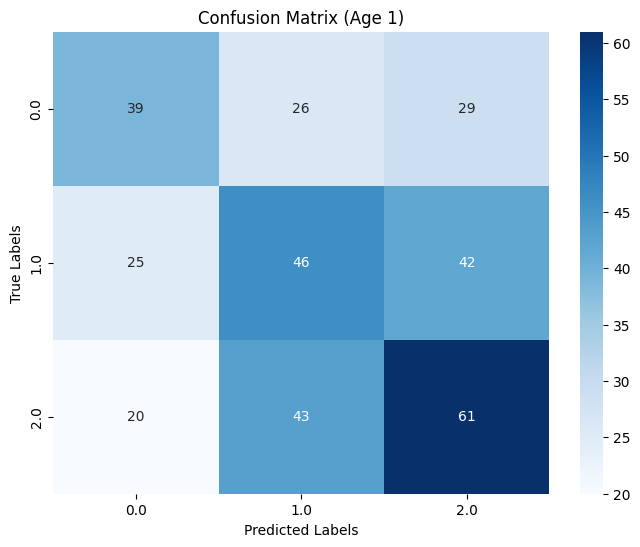

X:  (2009, 152)
y:  (2009,)
(2009, 95)
92
Selected Features: ['chatting_online', 'breakfast_routindays', 'breakfast_friday', 'saltysnack', 'soda', 'packed_juice', 'fastfoods', 'physical_activity', 'TV_watching_friday', 'computer_work_routinday', 'fight_number', 'mother_hookah', 'others_hookah', 'mother_smoker', 'sibling_smoker', 'others_smoker', 'confusion_number', 'worthless_number', 'insomnia_number', 'back_pain_number', 'worried_number', 'stomach_ache_number', 'smoke_escaping_problems', 'smoke_social_acceptance', 'smoke_confidence_boost', 'smoke_staying_awake', 'family_size', 'computer_ownership', 'livingparent', 'birth_weight', 'breast_feeding_duration', 'table_salt', 'usual_dairy', 'grains', 'meat', 'rice', 'potato', 'fruit_nut_substitute', 'increase_vegetables', 'reduce_sugar', 'reduce_fat', 'fresh_fruit_nondaily', 'litigant_friend', 'litigant_parent', 'litigant_sibling', 'comfort_mother_nadaram', 'comfort_father_nadaram', 'comfort_father_rahati', 'comfort_sister_nadaram', 'comfo

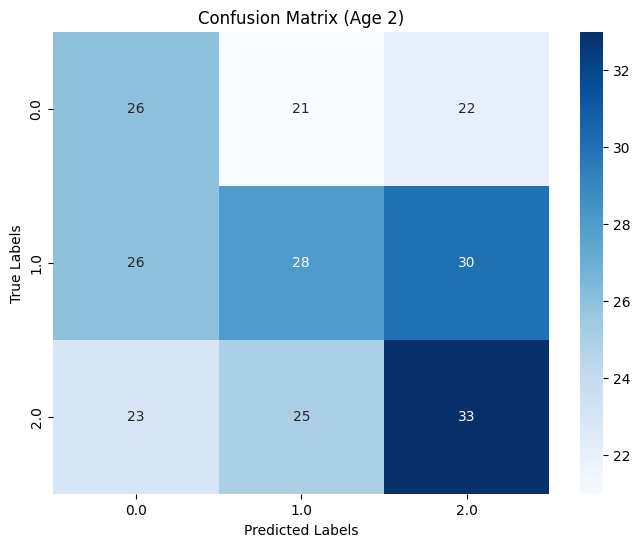

X:  (2303, 152)
y:  (2303,)
(2303, 86)
83
Selected Features: ['breakfast_friday', 'saltysnack', 'soda', 'dry_fruit', 'packed_juice', 'milk', 'fastfoods', 'physical_activity', 'TV_watching_routinday', 'TV_watching_friday', 'sleep_hours_routinday', 'sleep_hours_friday', 'injury_number', 'fight_number', 'bully_number', 'sibling_hookah', 'father_smoker', 'sibling_smoker', 'others_smoker', 'worthless_number', 'back_pain_number', 'worried_number', 'stomach_ache_number', 'anxiety_number', 'smoke_leisure', 'smoke_escaping_problems', 'smoke_anxiety_reduction', 'smoke_confidence_boost', 'smoke_focus', 'smoke_feeling_loved', 'computer_ownership', 'birth_weight', 'breast_feeding_duration', 'fatty_dairy', 'potato', 'reduce_fat', 'litigant_friend', 'comfort_mother_rahati', 'comfort_friend_rahati', 'comfort_father_nadaram', 'comfort_brother_nadaram', 'home_ownership_personal', 'home_ownership_rented', 'father_edu_diploma', 'father_edu_elementry education', 'father_edu_father died', 'father_edu_gradua

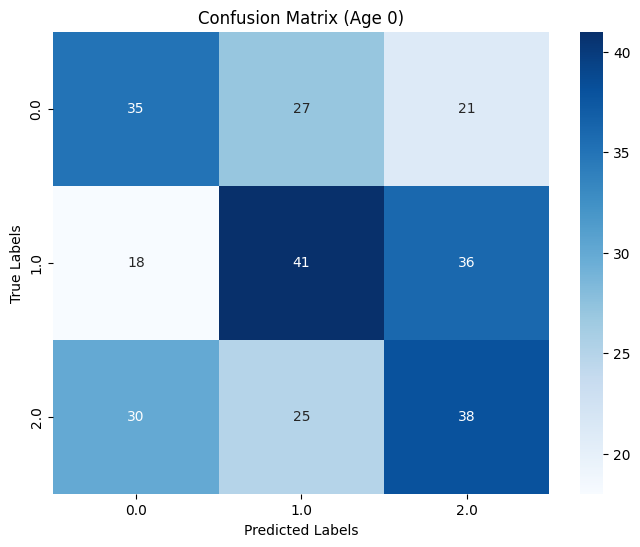

TypeError: list indices must be integers or slices, not str

In [89]:
catage = encoded_df['catage'].unique()
results = process_and_train_model_for_each_age(encoded_df, catage)

results_df = pd.DataFrame([{
    "catage": r["catage"],
    "accuracy": r["accuracy"],
    "num_samples": r["num_samples"],
    # "top_features": r["top_features"],
    "classification_report": r["classification_report"]
} for r in results])

In [77]:
results

([{'catage': 1,
   'accuracy': 0.4380664652567976,
   'num_samples': 2773,
   'classification_report': {'0.0': {'precision': 0.4880952380952381,
     'recall': 0.43617021276595747,
     'f1-score': 0.4606741573033708,
     'support': 94.0},
    '1.0': {'precision': 0.38392857142857145,
     'recall': 0.3805309734513274,
     'f1-score': 0.38222222222222224,
     'support': 113.0},
    '2.0': {'precision': 0.45185185185185184,
     'recall': 0.49193548387096775,
     'f1-score': 0.47104247104247104,
     'support': 124.0},
    'accuracy': 0.4380664652567976,
    'macro avg': {'precision': 0.4412918871252205,
     'recall': 0.43621222336275084,
     'f1-score': 0.4379796168560213,
     'support': 331.0},
    'weighted avg': {'precision': 0.4389562253232948,
     'recall': 0.4380664652567976,
     'f1-score': 0.43777567464318545,
     'support': 331.0}}},
  {'catage': 2,
   'accuracy': 0.3803418803418803,
   'num_samples': 2009,
   'classification_report': {'0.0': {'precision': 0.34426229